# Insurance Cost Prediction

The aim of this project is to build a regression model for predicting insurance costs of a health care for various clients. The data is available on <a href="https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv">Github</a>.

<p>Insurance costs can be influenced by many different factors. What comes to mind first, is obviously age and health of a person.</p>
<p>This dataset is characterized by the following columns:
<i>age</i>: age of primary beneficiary; <i>sex</i>: insurance contractor gender, female, male; <i>bmi</i>: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9; <i>children</i>: Number of children covered by health insurance / Number of dependents; <i>smoker</i>: tells if beneficiary is smoking; <i>region</i>: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest; <i>charges</i>: Individual medical costs billed by health insurance, which is the dependent variable.</p>

## Loading libraries and dataset overview

Firstly, I will load all the necessary libraries. I am going to use two regression methods - standard Linear Regression from Scikit-Learn library and XGBRegressor from XGBoost.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

Here I will load the dataset and explore it.

In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


What we can find out is there are not any missing values in the dataset. Another thing is that we will deal with people aged 18-64, which means that all the observations are in their working age. In case of that variable, mean and median are equal or close to the value of 39, so we cannot say the age data is skewed. We observe similar situation in case of all variables besides charges, where the mean is significantly higher than a median.

Now I will check the relation of age and insurance cost, which, as mentioned on the beginning, is one of the first suspects for increased charges.

Text(0.5, 1, 'Charges depending on Age')

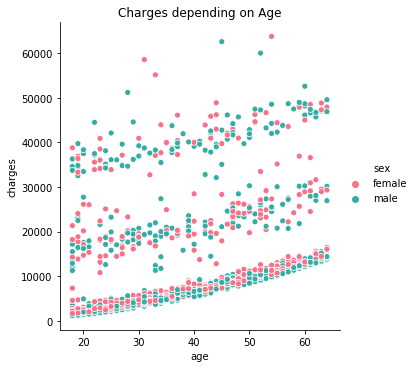

In [6]:
sns.relplot(x='age', y='charges', hue='sex', data=df, palette='husl')
plt.title('Charges depending on Age')

As the graph above shows, the cost indeed rises with age. There are 3 distinguishable patterns. To make it clearer, I will plot separate charts for females and males.

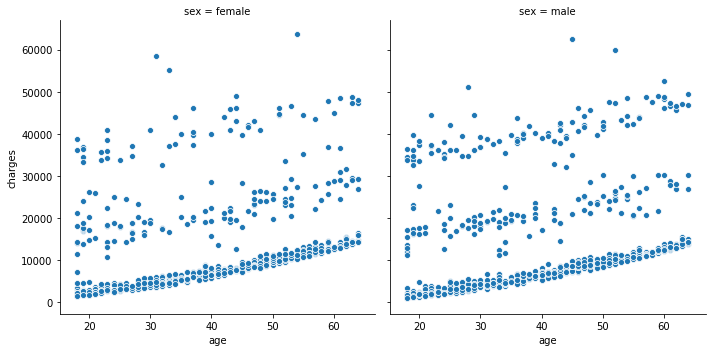

In [9]:
sns.relplot(x='age', y='charges', col='sex', data=df, palette='husl')

In both cases charges grow with age. It looks like costs for females are bit higher.

The next variable with potentially significant impact on insurance charges is the fact of smoking, which has negative impact on one's health. The below graphs will include both information about age and smoking.

Text(0.5, 1, 'Charges depending on Age and Smoking combined')

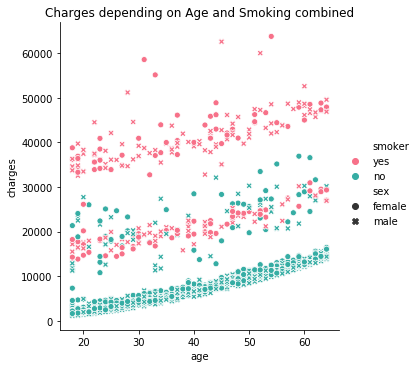

In [10]:
sns.relplot(x='age', y='charges', hue='smoker', style= 'sex', data=df, palette='husl')
plt.title('Charges depending on Age and Smoking combined')

With distinction of smokers, we see now that these 3 visible patterns from previous graph are acctually true. The one with lowest charges consists of non-smokers, the one in the middle includes mix of both groups, and the third group is formed solely by smokers.

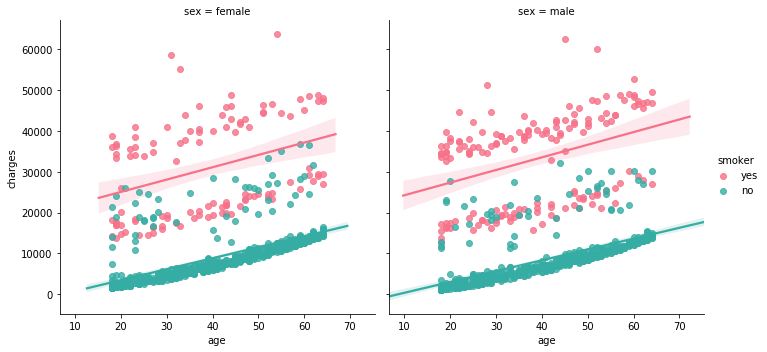

In [11]:
sns.lmplot(x='age', y='charges', hue='smoker', col='sex',data=df, palette='husl')

This relationship is true for males and females. Below I will display violin plots for both of these groups, depending exclusively on smoking.

Text(0.5, 1.0, 'Charges depending on Smoking by Sex')

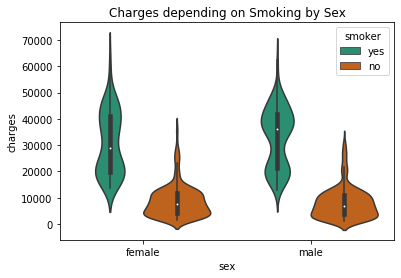

In [13]:
sns.violinplot(x="sex", y='charges', hue="smoker", data=df, palette='Dark2')
plt.title('Charges depending on Smoking by Sex')

Below I will look at the number of smoking and non-smoking males and females and the mean insurance charges for these groups.

In [14]:
df_grouped=df.groupby(['smoker', 'sex']).agg({'charges':'sum','sex':'count'})
df_grouped['mean_charges']= df_grouped['charges']/df_grouped['sex']
df_grouped=df_grouped.rename(columns={'sex':'count'})
df_grouped.index=[0,1,2,3]
df_grouped['smoker']=['no','no','yes','yes']
df_grouped['sex']=['female','male','female','male']
df_grouped=df_grouped[['smoker', 'sex','count','charges','mean_charges']]
df_grouped

,smoker,sex,count,charges,mean_charges
0,no,female,547,4.792977e+06,8762.297300
1,no,male,517,4.181085e+06,8087.204731
2,yes,female,115,3.528085e+06,30678.996276
3,yes,male,159,5.253679e+06,33042.005975


We have 547 females and 517 males that do not smoke,  while there are 115 smoking females and 159 smoking males. The mean charges for smokers are much higher than for non-smokers. These are 8762 and 8087 for females and males comparing to 30679 and 33042 for smokers. The distribution is visiualised below.

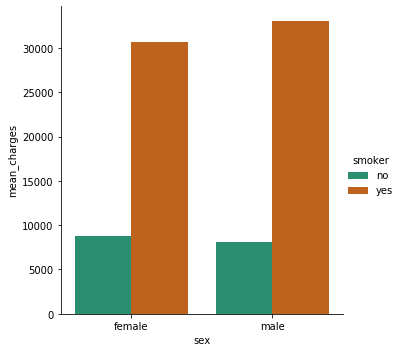

In [16]:
sns.catplot(x='sex',y='mean_charges',hue='smoker',kind='bar',data=df_grouped, palette='Dark2')

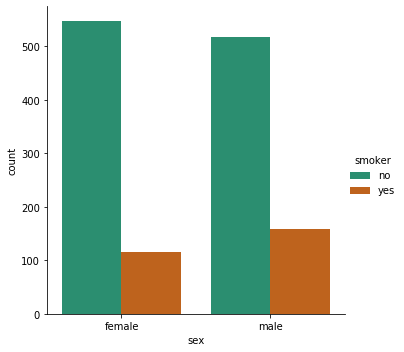

In [15]:
sns.catplot(x='sex',y='count',hue='smoker',kind='bar',data=df_grouped, palette='Dark2')

While, on average, for non-smoking females the charges are higher than of non-smoking males, it is in contrast to smoking groups, where males cost more. We also see that higher percentage of whole male population is smoking.

The next variable that is related to health is BMI, short for Body Mass Index. This indicator is commonly used to diagnose obesity or underweight. While it is not completely useful for e.g. bodybuilders, we can assume that higher BMI is caused by excessive fat and therefore harmful for patient's overall health. I will therefore check the relation of BMI and insurance charges.

Text(0.5, 1, 'Charges depending on BMI')

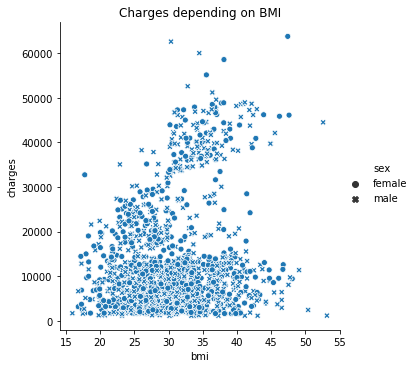

In [17]:
sns.relplot(x='bmi',y='charges',style='sex',data=df)
plt.title('Charges depending on BMI')

From the chart above, it is not that clear if higher BMI has impact on insurance cost. However, when combining with smoking, we see interesting relation.

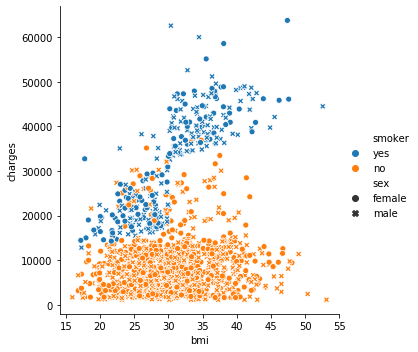

In [18]:
sns.relplot(x='bmi',y='charges',hue='smoker',style='sex',data=df)

While, for non-smokers, it is hard to confirm any link, for smokers higher BMI is indeed relevant when it comes to higher charges. Plots below show it is tru for both males and females.

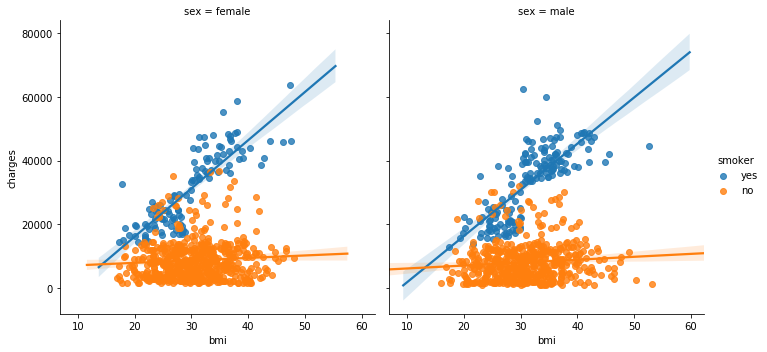

In [21]:
sns.lmplot(x='bmi',y='charges',hue='smoker', col='sex',data=df)

So far I just relied on intuition. It is wise to create pairplots to check any possible dependancy I might have missed.

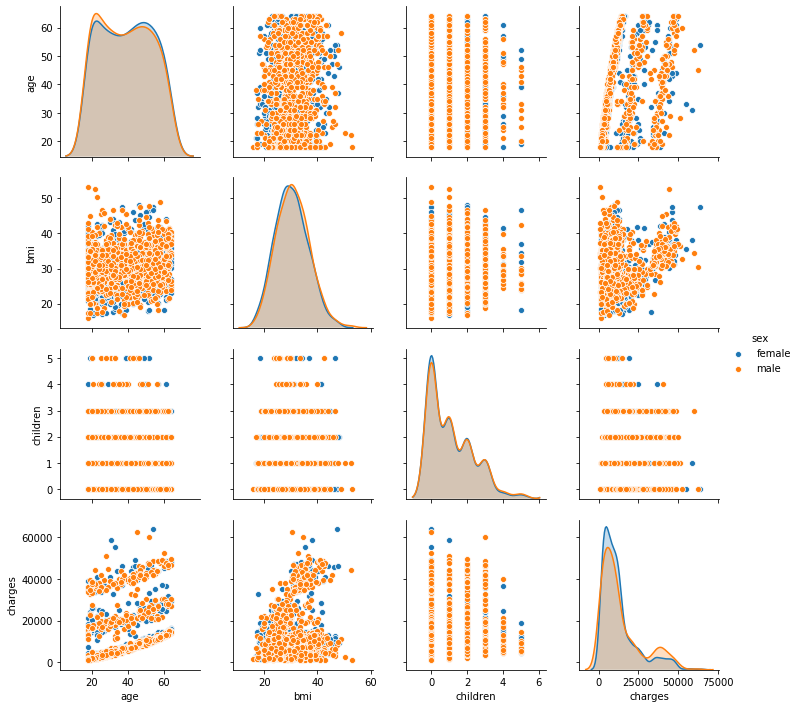

In [22]:
sns.pairplot(df, vars=['age','bmi','children','charges'], hue='sex')

The interesting thing here is that, for example, the mean expenses start to get lower with 3+ number of kids. It is probably because, while total cost is higher, for bigger families adding next person costs less, which lowers average per capita. Violin plots below also indicate higher spread for males than for females.

Text(0.5, 1, 'Charges depending on number of children')

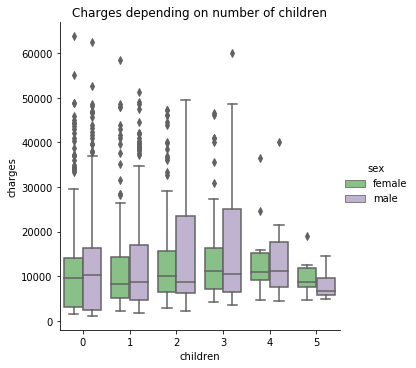

In [23]:
sns.catplot(x="children", y='charges', hue='sex', kind='box',data=df, palette= 'Accent')
plt.title('Charges depending on number of children')

Again, we see that smokers have to spend much more than non-smokers.

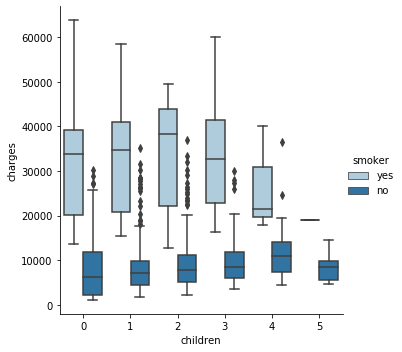

In [24]:
sns.catplot(x="children", y='charges', hue='smoker', kind='box',data=df , palette= 'Paired')

Below is the dataframe with mean and median charges within groups defined by number of children.

In [25]:
df_grouped2=df.groupby('children').agg({'charges':'sum','sex':'count'})
df_grouped2['mean_charges2']=df_grouped2['charges']/df_grouped2['sex']
df_grouped2['median_charges']=df.groupby('children')['charges'].median()
df_grouped2

,charges,sex,mean_charges2,median_charges
children,,,,
0,7.098070e+06,574,12365.975602,9856.95190
1,4.124900e+06,324,12731.171832,8483.87015
2,3.617655e+06,240,15073.563734,9264.97915
3,2.410785e+06,157,15355.318367,10600.54830
4,3.462664e+05,25,13850.656311,11033.66170
5,1.581486e+05,18,8786.035247,8589.56505


Here is more detailed dataframe, covering also the information about sex and smoking.

In [26]:
df_grouped3=df.groupby(['children','sex','smoker']).agg({'sex':'count', 'charges':'sum'})
df_grouped3['mean_charges2']=df_grouped3['charges']/df_grouped3['sex']
df_grouped3

sex       charges  mean_charges2
children sex    smoker                                  
0        female no      236  1.814443e+06    7688.318863
                yes      53  1.626308e+06   30685.059887
         male   no      223  1.679370e+06    7530.806677
                yes      62  1.977949e+06   31902.398075
1        female no      133  1.164889e+06    8758.560884
                yes      25  7.566063e+05   30264.253915
         male   no      130  1.018829e+06    7837.147396
                yes      36  1.184576e+06   32904.876848
2        female no       97  9.624124e+05    9921.777645
                yes      22  6.966043e+05   31663.833195
         male   no       88  7.938099e+05    9020.567024
                yes      33  1.164829e+06   35297.837461
3        female no       63  6.381091e+05   10128.716357
                yes      14  4.295425e+05   30681.604257
         male   no       55  4.964042e+05    9025.530139
                yes      25  8.467292e+05   33869.169434
4        female no       11  1.533144e+05   13937.674562
         male   no       11  1.133552e+05   10305.014255
                yes       3  7.959683e+04   26532.276933
5        female no        7  5.980879e+04    8544.113050
                yes       1  1.902326e+04   19023.260000
         male   no       10  7.931658e+04    7931.658310

The last variable that was not investigated yet is <i>region</i>. The violin plots are pretty much the same for all region, with <i>southeast</i> with bit higher charges comparing to the rest of the areas.

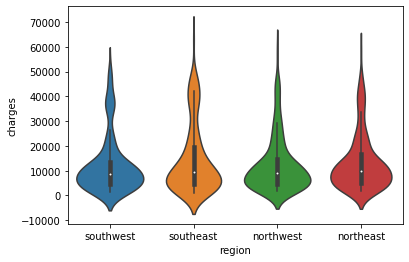

In [27]:
sns.violinplot(x="region", y='charges', data=df)

As expected, being a smoker poses higher medical charges to face.

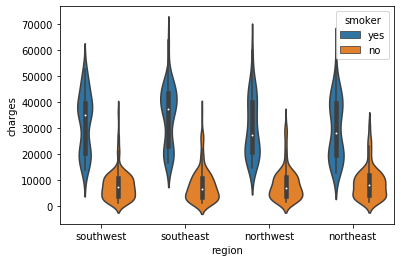

In [28]:
sns.violinplot(x="region", y='charges', hue="smoker", data=df)

The tables in the next 2 cells describe mean charges for residents of a particular region.

In [29]:
df_grouped4=df.groupby('region').agg({'charges':'sum','sex':'count'})
df_grouped4['mean_charges3']=df_grouped4['charges']/df_grouped4['sex']
df_grouped4

,charges,sex,mean_charges3
region,,,
northeast,4.343669e+06,324,13406.384516
northwest,4.035712e+06,325,12417.575374
southeast,5.363690e+06,364,14735.411438
southwest,4.012755e+06,325,12346.937377


In [30]:
df_grouped5=df.groupby(['region','smoker']).agg({'sex':'count', 'charges':'sum'})
df_grouped5['mean_charges']=df_grouped5['charges']/df_grouped5['sex']
df_grouped5

sex       charges  mean_charges
region    smoker                                 
northeast no      257  2.355542e+06   9165.531672
          yes      67  1.988127e+06  29673.536473
northwest no      267  2.284576e+06   8556.463715
          yes      58  1.751136e+06  30192.003182
southeast no      273  2.192795e+06   8032.216309
          yes      91  3.170895e+06  34844.996824
southwest no      267  2.141149e+06   8019.284513
          yes      58  1.871606e+06  32269.063494

## Data preprocessing

Since regression machine learning algorithims require numerical values, we need to preprocess the categorical variables first. We know that <i>sex</i> has 2 categories male/female, <i>smoker</i> is divided into yes/no, and there are 4 <i>regions</i>. Here is the summary.

In [32]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

I will now encode the binary variables and split <i>region</i> into 4.

In [33]:
encoder=LabelEncoder()
encoder.fit(df['sex'].drop_duplicates())
df['sex']=encoder.transform(df['sex'])
encoder.fit(df['smoker'].drop_duplicates())
df['smoker']=encoder.transform(df['smoker'])
df1=pd.get_dummies(df['region'], prefix='region')
df= pd.concat([df,df1], axis=1).drop(['region'],axis=1)
print(df.head(2))
df.dtypes

   age  sex    bmi  children  smoker     charges  region_northeast  \
0   19    0  27.90         0       1  16884.9240                 0   
1   18    1  33.77         1       0   1725.5523                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  


age                   int64
sex                   int32
bmi                 float64
children              int64
smoker                int32
charges             float64
region_northeast      uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
dtype: object

## Modeling

In this project, our aim is to correctly predict the exact cost. We therefore need to build regression model. To achieve this goal, I will make a comparison of Linear Regression and XGBoost Regressor, starting with the former.

Before training the model, we need to build a set of X and y variables. The next step will be spliting them into training and test sets. The metric used for assessing the model's quality is <i>root mean square error</i>. The lower this value is, the better.

In [37]:
y = df['charges']
X = df.drop(['charges'], axis=1)

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("RMSE: %f" % (rmse))

RMSE: 6168.155294


We have got a result of 6168. The next method is XGBRegressor. Comparing to the Linear Regression model above, I will split the training data into training and validation sets. The code below shows also the feature importance, indicating the significance of a particular variables.

[19:52:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 4871.804946


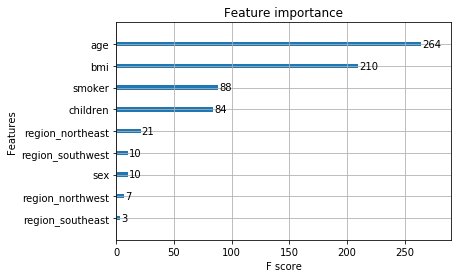

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=21)


xgbr = XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgbr.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)
y_pred_xgbr = xgbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgbr))
print("RMSE: %f" % (rmse))
plot_importance(xgbr)

It looks like XGBRegressor works better than Linear Regression, as we achieved a RMSE of 4871. According to the feature importance plot, the variables like sex and regions have lower meaning when defining an insurance cost. I will therefore drop them out to see if the model gets more quality.

In [45]:
X_dropped = df.drop(['sex','region_northeast','region_northwest','region_southeast','region_southwest'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.25, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=21)

xgbr2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgbr2.fit(X_train, y_train, early_stopping_rounds=5,eval_set=[(X_val, y_val)], verbose=False)
y_pred_xgbr2 = xgbr2.predict(X_test)

rmse2 = np.sqrt(mean_squared_error(y_test, y_pred_xgbr2))
print("RMSE: %f" % (rmse2))

[19:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 79.573048


After removing these 5 variables, the RMSE is much lower than it was. It turns out it was a good decision to exclude them from model.

## Summary

This project was a short presentation of data visiualization methods and simple regression models. With few lines of code, I have built quite effective tool for predicting prices. This example also shows, that in some cases it is better to use less variables to reduce unnecessary noise.